In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge

def read_data(file_path):

    df = pd.read_csv(file_path)
    df = df.rename(columns={"Time (s)": "t", "X (m/s^2)": "x", "Y (m/s^2)": "y", "Z (m/s^2)": "z"})
    return df

def label_data(df, label):

    df['activity'] = label
    return df

def preprocess_data(df, window_size, alpha=1.0):

    # Remove first and last 3 seconds
    df = df.iloc[int(3 * df.shape[0] / 30):int(-3 * df.shape[0] / 30)]

    # Apply rolling mean with window size
    df_windowed = df.rolling(window_size).mean().dropna()
    df_windowed = df_windowed.sample(frac=1).reset_index(drop=True)

    # Apply normalization to x,y,z columns only with L2 regularization
    scaler = MinMaxScaler()
    X = df_windowed[['x', 'y', 'z']]
    ridge = Ridge(alpha=alpha)
    X_scaled = scaler.fit_transform(X)
    X_regularized = ridge.transform(X_scaled)
    df_windowed[['x', 'y', 'z']] = X_regularized

    return df_windowed


def preprocess_data(df, window_size, alpha=1.0):

    # Remove first and last 3 seconds
    df = df.iloc[int(3 * df.shape[0] / 30):int(-3 * df.shape[0] / 30)]

    # Apply rolling mean with window size
    df_windowed = df.rolling(window_size).mean().dropna()
    df_windowed = df_windowed.sample(frac=1).reset_index(drop=True)

    # Apply normalization to x,y,z columns only with L2 regularization
    scaler = MinMaxScaler()
    X = df_windowed[['x', 'y', 'z']]
    ridge = Ridge(alpha=alpha)
    y = X.values
    X_scaled = scaler.fit_transform(X)
    ridge.fit(X_scaled, y)
    X_regularized = ridge.predict(X_scaled)
    df_windowed[['x', 'y', 'z']] = X_regularized

    return df_windowed


def segment_data(data, window_size=5, sample_rate=100):
    samples = len(data)
    window_samples = window_size * sample_rate
    segments = []
    for i in range(0, samples, window_samples):
        segment = data[i:i+window_samples]
        if len(segment) == window_samples:
            segments.append(segment)
    np.random.shuffle(segments)
    
    return segments


kieran_walking = read_data('Accelerometer_Walking_Kieran.csv').reset_index(drop=True)
kieran_jumping = read_data('Accelerometer_Jumping_Kieran.csv').reset_index(drop=True)
amir_walking = read_data('Accelerometer_Walking_Amir.csv').reset_index(drop=True)
amir_jumping = read_data('Accelerometer_Jumping_Amir.csv').reset_index(drop=True)
jack_walking = read_data('Accelerometer_Walking_Jack.csv').reset_index(drop=True)
jack_jumping = read_data('Accelerometer_Jumping_Jack.csv').reset_index(drop=True)


kieran_walking = label_data(kieran_walking, 0)
kieran_jumping = label_data(kieran_jumping, 1)
amir_walking = label_data(amir_walking, 0)
amir_jumping = label_data(amir_jumping, 1)
jack_walking = label_data(jack_walking, 0)
jack_jumping = label_data(jack_jumping, 1)


window_size = 5 
kieran_walking_windowed = preprocess_data(kieran_walking, window_size)
kieran_jumping_windowed = preprocess_data(kieran_jumping, window_size)
amir_walking_windowed = preprocess_data(amir_walking, window_size)
amir_jumping_windowed = preprocess_data(amir_jumping, window_size)
jack_walking_windowed = preprocess_data(jack_walking, window_size)
jack_jumping_windowed = preprocess_data(jack_jumping, window_size)

# kieran_walking_segmented = segment_data(kieran_walking_windowed)
# kieran_jumping_segmented = segment_data(kieran_jumping_windowed)
# amir_walking_segmented = segment_data(amir_walking_windowed )
# amir_jumping_segmented = segment_data(amir_jumping_windowed )
# jack_walking_segmented = segment_data(jack_walking_windowed )
# jack_jumping_segmented = segment_data(jack_jumping_windowed)



df_concat = pd.concat([kieran_walking_windowed, kieran_jumping_windowed,
amir_walking_windowed, amir_jumping_windowed,
jack_walking_windowed, jack_jumping_windowed], ignore_index=True)


df_concat.to_csv('accelerometer_data.csv', index=True)

In [ ]:
df_concat = df_concat.reset_index(drop=False)
df_concat = df_concat.rename(columns={"index": "index_col"})
df_concat.to_csv('accelerometer_data1.csv', index=False)





Create a labls dataframe for y train and test

In [4]:
df_newdata = pd.read_csv('accelerometer_data.csv')
# Randomly delete 500 rows
indices_to_delete = df_newdata.sample(n=4).index
df_newdata = df_newdata.drop(indices_to_delete)

pd.DataFrame(df_newdata)

activity_labels = pd.DataFrame(df_newdata['activity'])
pd.DataFrame(activity_labels)



,activity
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
145735,1.0
145736,1.0
145737,1.0
145738,1.0


# Feature Extraction 

In [5]:
import numpy as np
import pandas as pd
from scipy import stats

def extract_features(data):
    features = []
    for window in data:
        feature_list = []
        combined_data = window[:, 1:4].ravel()

        # Calculate the features for combined axis data
        max_value = np.max(combined_data)
        min_value = np.min(combined_data)
        range_value = max_value - min_value
        mean_value = np.mean(combined_data)
        median_value = np.median(combined_data)
        variance = np.var(combined_data)
        skewness = stats.skew(combined_data)
        rms = np.sqrt(np.mean(combined_data ** 2))
        kurtosis = stats.kurtosis(combined_data)
        std_dev = np.std(combined_data)

        # Add the features to the feature list
        feature_list.extend([max_value, min_value, range_value, mean_value, median_value,
                             variance, skewness, rms, kurtosis, std_dev])

        # Add the feature list for combined axis data to the feature list for the window
        features.append(feature_list)

    return np.array(features)

# Load and preprocess data
window_size = 5
df = pd.read_csv('accelerometer_data.csv', index_col=0)
X_all = df[['t', 'x', 'y', 'z']]
y = df['activity'].values
X_windowed = np.array([X_all.values[i:i+window_size, :] for i in range(0, X_all.shape[0]-window_size+1)])

# Extract total features from all axes
X_features = extract_features(X_windowed)

# Save features to CSV file
feature_names = ['max', 'min', 'range', 'mean', 'median', 'variance',
                 'skewness', 'rms', 'kurtosis', 'std_dev']
df_features = pd.DataFrame(X_features, columns=[f'features_{feature}' for feature in feature_names])
df_features['activity'] = y[window_size-1:]
df_features.to_csv('accelerometer_total_features.csv', index=False)


In [6]:


pd.DataFrame(df_features)

,features_max,features_min,features_range,features_mean,features_median,features_variance,features_skewness,features_rms,features_kurtosis,features_std_dev,activity
0,13.023400,-7.772116,20.795516,2.459277,0.375458,31.236850,0.319907,6.106136,-0.568233,5.588994,0.0
1,13.001296,-7.772116,20.773413,2.362411,0.375458,31.585911,0.345203,6.096466,-0.596451,5.620134,0.0
2,14.939537,-7.772116,22.711654,2.563743,0.375458,41.197434,0.503843,6.911600,-0.690198,6.418523,0.0
3,14.939537,-7.772116,22.711654,2.700706,0.375458,40.815988,0.467221,6.936123,-0.716051,6.388739,0.0
4,14.939537,-6.341021,21.280559,2.855209,0.375458,38.512766,0.558599,6.831177,-0.741543,6.205865,0.0
...,...,...,...,...,...,...,...,...,...,...,...
145731,23.331276,-32.182058,55.513334,-1.152405,0.180258,142.357731,-0.727954,11.986900,1.631883,11.931376,1.0
145732,23.331276,-32.642887,55.974164,-3.044909,0.180258,202.787903,-0.749864,14.562259,0.370461,14.240362,1.0
145733,23.331276,-33.788269,57.119545,-3.541950,-1.829529,207.547046,-0.719106,14.835513,0.377698,14.406493,1.0
145734,23.331276,-33.788269,57.119545,-3.284957,0.180258,209.185580,-0.760694,14.831606,0.378490,14.463249,1.0


# Classification

Accuracy: 0.9092, Recall: 0.8848


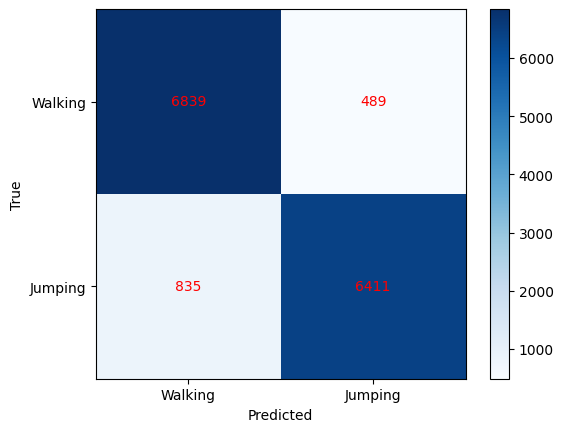

 F1 Score: 0.9064


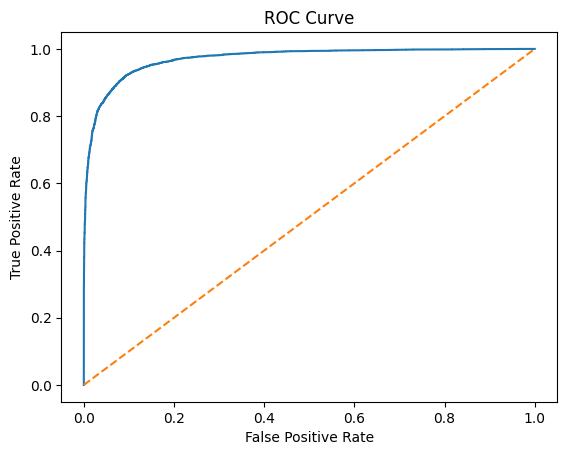

AUC: 0.9713
Cross-validation scores: [0.90641558 0.90595814 0.90462031 0.90908051 0.90843245]
Average cross-validation score: 0.9069014000173242


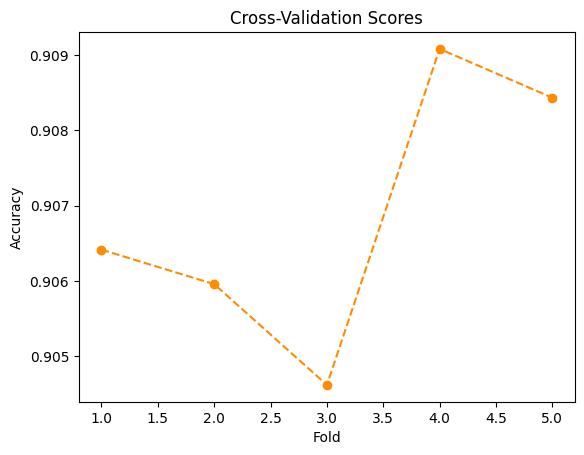

In [7]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, f1_score, roc_curve, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler

# Read the datasets
# Split data into train and test sets
X = df_features.drop("activity", axis=1)
y = df_features["activity"] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Define logistic regression classifier with a pipeline that includes data normalization
log_reg = LogisticRegression(max_iter=10000, penalty='l2')

classifier = make_pipeline(StandardScaler(), log_reg)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model
classifier.fit(X_train, y_train)

# Save the trained model using pickle
with open('model.pkl', 'wb') as file:
    pickle.dump(classifier, file)

# Calculate predictions and probabilities
y_pred = classifier.predict(X_test)
y_probs = classifier.predict_proba(X_test)[:, 1]

# Calculate and print classification accuracy and recall
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}, Recall: {recall:.4f}')

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(2), ['Walking', 'Jumping'])
plt.yticks(np.arange(2), ['Walking', 'Jumping'])
plt.xlabel('Predicted')
plt.ylabel('True')
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

# Calculate and print F1 score for z acceleration
f1 = f1_score(y_test, y_pred)
print(f' F1 Score: {f1:.4f}')

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Calculate and print AUC
auc = roc_auc_score(y_test, y_probs)
print(f'AUC: {auc:.4f}')

# Perform cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(log_reg, X_train_scaled, y_train, cv=cv, scoring='accuracy')
print(f'Cross-validation scores: {cv_scores}')
print(f'Average cross-validation score: {cv_scores.mean()}')

# Plot the cross-validation scores
plt.figure()
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o', linestyle='--', color='darkorange')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Scores')
plt.show()


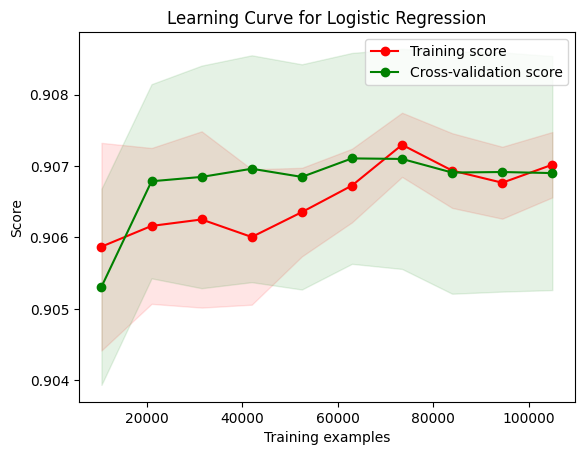

In [8]:
from sklearn.model_selection import train_test_split, learning_curve
# Define a function to plot the learning curve
def plot_learning_curve(train_sizes, train_scores, test_scores, title):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.title(title)
    plt.show()

# Calculate the learning curve
train_sizes, train_scores, test_scores = learning_curve(log_reg, X_train_scaled, y_train, cv=cv, train_sizes=np.linspace(0.1, 1.0, 10))

# Plot the learning curve
plot_learning_curve(train_sizes, train_scores, test_scores, title='Learning Curve for Logistic Regression')

/Users/kierancosgrove/opt/anaconda3/envs/ELEC390/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


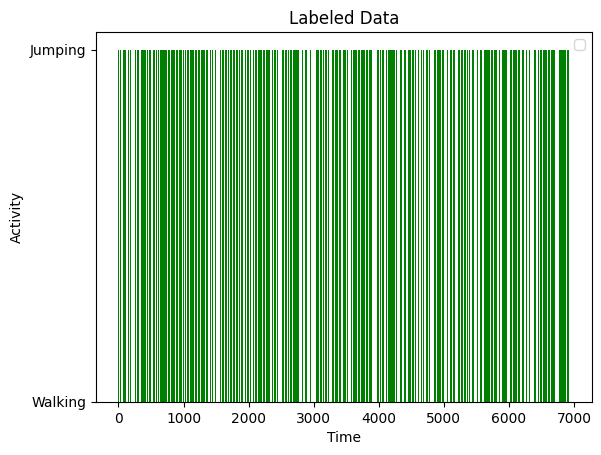

In [2]:
import tkinter as tk
from tkinter import filedialog
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import os
import pickle
from scipy import stats

# Load the trained classifier
def load_model(): # for loading trained models from separate training code
    with open('model.pkl', 'rb') as f:
        model = pickle.load(f)
    return model

def read_data(file_path):
    df = pd.read_csv(file_path)
    df = df.rename(columns={"Time (s)": "t", "X (m/s^2)": "x", "Y (m/s^2)": "y", "Z (m/s^2)": "z"})
    return df

def preprocess_data(df, window_size, alpha=1.0):
    df = df.iloc[int(3 * df.shape[0] / 30):int(-3 * df.shape[0] / 30)]
    df_windowed = df.rolling(window_size).mean().dropna()
    df_windowed = df_windowed.sample(frac=1).reset_index(drop=True)

    scaler = MinMaxScaler()
    X = df_windowed[['x', 'y', 'z']]
    ridge = Ridge(alpha=alpha)
    y = X.values
    X_scaled = scaler.fit_transform(X)
    ridge.fit(X_scaled, y)
    X_regularized = ridge.predict(X_scaled)
    df_windowed[['x', 'y', 'z']] = X_regularized

    return df_windowed

def extract_features(data):
    features = []
    for window in data:
        feature_list = []
        combined_data = window[:, 1:4].ravel()

        max_value = np.max(combined_data)
        min_value = np.min(combined_data)
        range_value = max_value - min_value
        mean_value = np.mean(combined_data)
        median_value = np.median(combined_data)
        variance = np.var(combined_data)
        skewness = stats.skew(combined_data)
        rms = np.sqrt(np.mean(combined_data ** 2))
        kurtosis = stats.kurtosis(combined_data)
        std_dev = np.std(combined_data)

        feature_list.extend([max_value, min_value, range_value, mean_value, median_value,
                             variance, skewness, rms, kurtosis, std_dev])

        features.append(feature_list)

    return np.array(features)

def browse_file():
    file_path = filedialog.askopenfilename(filetypes=[("CSV Files", "*.csv")])
    if file_path:
        process_data(file_path)

def process_data(file_path):
    input_df = read_data(file_path)
    window_size = 5
    input_df_windowed = preprocess_data(input_df, window_size)
    X_all = input_df_windowed[['t', 'x', 'y', 'z']]
    input_df_segmented = np.array([X_all.values[i:i+window_size, :] for i in range(0, X_all.shape[0]-window_size+1)])
    X_features = extract_features(input_df_segmented)
    classifier = load_model()
    y_pred = classifier.predict(X_features)
    plot_labeled_data(y_pred)
    save_output_to_csv(y_pred)

def plot_labeled_data(y_pred):
    df = pd.DataFrame(data=y_pred, columns=['activity'])
    df['index'] = df.index
    walking = df['activity'] == 0
    jumping = df['activity'] == 1
    plt.figure()
    plt.bar(df[walking]['index'], df[walking]['activity'], color='blue')
    plt.bar(df[jumping]['index'], df[jumping]['activity'], color='green')
    plt.xlabel('Time')
    plt.ylabel('Activity')
    plt.title('Labeled Data')
    plt.yticks([0, 1], ['Walking', 'Jumping'])
    plt.legend()
    plt.show()

def save_output_to_csv(y_pred):
    output_df = pd.DataFrame(data=y_pred, columns=['activity'])
    output_df['index'] = output_df.index
    output_df.to_csv("output.csv", index=False)

root = tk.Tk()
root.title("Activity Classifier")

frame = tk.Frame(root, padx=20, pady=20)
frame.pack()

label = tk.Label(frame, text="Select a CSV file to predict activities (Walking or Jumping):")
label.pack(pady=(0, 10))

button = tk.Button(frame, text="Browse", command=browse_file)
button.pack()

root.mainloop()

# Deployment Alternate

/Users/kierancosgrove/opt/anaconda3/envs/ELEC390/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


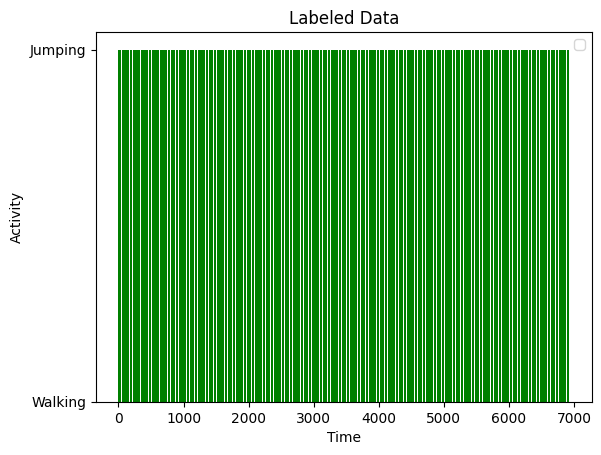

In [4]:
import tkinter as tk
from tkinter import filedialog
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import os
import pickle
from scipy import stats

# Load the trained classifier
def load_model(): # for loading trained models from separate training code
    with open('model.pkl', 'rb') as f:
        model = pickle.load(f)
    return model

def read_data(file_path):
    df = pd.read_csv(file_path)
    df = df.rename(columns={"Time (s)": "t", "X (m/s^2)": "x", "Y (m/s^2)": "y", "Z (m/s^2)": "z"})
    return df

def preprocess_data(df, window_size):

    # Remove first and last 3 seconds
    df = df.iloc[int(3 * df.shape[0] / 30):int(-3 * df.shape[0] / 30)]

    # Apply rolling mean with window size
    df_windowed = df.rolling(window_size).mean().dropna()
    df_windowed = df_windowed.sample(frac=1).reset_index(drop=True)

    # Apply normalization to x,y,z columns only
    scaler = MinMaxScaler()
    X = df_windowed[['x', 'y', 'z']]
    X_scaled = scaler.fit_transform(X)
    df_windowed[['x', 'y', 'z']] = X_scaled

    return df_windowed

def extract_features(data):
    features = []
    for window in data:
        feature_list = []
        combined_data = window[:, 1:4].ravel()

        max_value = np.max(combined_data)
        min_value = np.min(combined_data)
        range_value = max_value - min_value
        mean_value = np.mean(combined_data)
        median_value = np.median(combined_data)
        variance = np.var(combined_data)
        skewness = stats.skew(combined_data)
        rms = np.sqrt(np.mean(combined_data ** 2))
        kurtosis = stats.kurtosis(combined_data)
        std_dev = np.std(combined_data)

        feature_list.extend([max_value, min_value, range_value, mean_value, median_value,
                             variance, skewness, rms, kurtosis, std_dev])

        features.append(feature_list)

    return np.array(features)

def browse_file():
    file_path = filedialog.askopenfilename(filetypes=[("CSV Files", "*.csv")])
    if file_path:
        process_data(file_path)

def process_data(file_path):
    input_df = read_data(file_path)
    window_size = 5
    input_df_windowed = preprocess_data(input_df, window_size)
    X_all = input_df_windowed[['t', 'x', 'y', 'z']]
    input_df_segmented = np.array([X_all.values[i:i+window_size, :] for i in range(0, X_all.shape[0]-window_size+1)])
    X_features = extract_features(input_df_segmented)
    classifier = load_model()
    y_pred = classifier.predict(X_features)
    plot_labeled_data(y_pred)
    save_output_to_csv(y_pred)

def plot_labeled_data(y_pred):
    df = pd.DataFrame(data=y_pred, columns=['activity'])
    df['index'] = df.index
    walking = df['activity'] == 0
    jumping = df['activity'] == 1
    plt.figure()
    plt.bar(df[walking]['index'], df[walking]['activity'], color='blue')
    plt.bar(df[jumping]['index'], df[jumping]['activity'], color='green')
    plt.xlabel('Time')
    plt.ylabel('Activity')
    plt.title('Labeled Data')
    plt.yticks([0, 1], ['Walking', 'Jumping'])
    plt.legend()
    plt.show()

def save_output_to_csv(y_pred):
    output_df = pd.DataFrame(data=y_pred, columns=['activity'])
    output_df['index'] = output_df.index
    output_df.to_csv("output.csv", index=False)

root = tk.Tk()
root.title("Activity Classifier")

frame = tk.Frame(root, padx=20, pady=20)
frame.pack()

label = tk.Label(frame, text="Select a CSV file to predict activities (Walking or Jumping):")
label.pack(pady=(0, 10))

button = tk.Button(frame, text="Browse", command=browse_file)
button.pack()

root.mainloop()